<a href="https://colab.research.google.com/github/inlytica-Library/Dataset_Simple_Linear_Regression/blob/main/sales_funnel_valuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [279]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch


Inputs:

In [280]:
# Simulation parameters
N   = 100_000
rng = np.random.default_rng(42)  # This is the recommended random number generator since NumPy 1.17

In [281]:
# Simulate funnel deals / stage and funnel stages

rng_deals = np.random.default_rng(7)

# Funnel Stages
stage_probabilities  = np.array([0.10, 0.35, 0.60, 0.90], float)
stage_counts = np.array([50,   30,   15,   5  ], int)  # totals 100

medians_by_stage = np.array([300_000, 300_000, 300_000, 300_000], float)

sigma_by_stage   = np.array([0.8, 0.6, 0.5, 0.4], float)

# Generate per-stage deal values (lognormal with given medians/sigmas)
deal_values_by_stage = []
for median, sigma, n in zip(medians_by_stage, sigma_by_stage, stage_counts):
    mu = np.log(median)            # lognormal median = exp(mu)
    vals = rng.lognormal(mean=mu, sigma=sigma, size=n)
    vals = np.round(vals / 1000) * 1000  # round to nearest $1k (optional)
    deal_values_by_stage.append(vals.astype(float))

deal_values = np.concatenate(deal_values_by_stage)            # shape (100,)
stage_probabilities_expanded = np.repeat(stage_probabilities, stage_counts) # shape (100,)

In this case, the management team estimated their funnel value to be in the $ 10.0 - $ 10.5 million range.

In [282]:

acquisition_guidance = (deal_values * stage_probabilities_expanded).sum()
acquisition_guidance_band = (round(acquisition_guidance-500_000,-6), round(acquisition_guidance + 500_000,-6))  # Where the acquistion target executives believe the funnel amount will land.



Tuning Parameters

In [283]:
# Stage Parameters

probability_uncertainity = .6 #Tune 0-1

# Deal Parameters
deal_size_starting_volatility = .45
deal_size_tightening_factor = .35
deal_size_tightening_min_volatility = 0.15
deal_size_tightening_max_volatility = 0.4

deal_size_skew = -8.0
deal_size_taper = 1.2




To solve the dual problems of uncertainity in the actual probabilities of closing and the fact that a 20% close (for example) means that 1 out of 5 deals will close rather than "we will receive 20% of the dollars", we sample from a beta distribution for N runs for each probability to get a probability of closing give our uncertainity. This uncertainity of the probability of closing is influenced by a concentration factor that goes up as the probability gets higher. This is because as the deal stage progresses, we assume that more is known about the deal and the forecast is more accurate. Then, using each probability of closing as the probability in a binomial distribution, we do a coin flip to determine whether or not the deal closes. This would be a 0 or a 1.

In [284]:

def log_interp(a, b, t):
    # Geometric interpolation from a -> b as t goes 0->1
    return a * (b / a) ** t

def concentration_factor_for_probability_of_closing(p, noise_dial,
                                                   tight=10_000.0, loose=1.2,
                                                   min_mult=1.0, max_mult=4.0,
                                                   curve=2.0):
    """
    Returns a vector of kappas (same shape as p).
      - noise_dial controls global tightness (0 tight .. 1 loose)
      - stage multiplier increases with p**curve so later stages are tighter
    """
    # global dial
    k_global = log_interp(tight, loose, noise_dial)

    # stage multiplier grows with p (later stages => higher concentration)
    stage_mult = min_mult + (max_mult - min_mult) * (p ** curve)

    # final per-stage kappa
    kappa = k_global * stage_mult
    return kappa

# Vector of per-stage concentrations (shape matches stage_probabilities)
stage_concentration = concentration_factor_for_probability_of_closing(
    stage_probabilities, probability_uncertainity
)

# Optional: quick sanity check
# print("kappa by stage:", stage_concentration)

alpha_probabilities = stage_probabilities * stage_concentration
beta_probabilities  = (1.0 - stage_probabilities) * stage_concentration

win_probabilities_stage = rng.beta(alpha_probabilities, beta_probabilities,
                                   size=(N, stage_probabilities.size))  # (N, 4)
win_probabilities = np.repeat(win_probabilities_stage, stage_counts, axis=1)
win_binomial = rng.binomial(1, win_probabilities)




Now we will create a matrix of deal size multipliers given our uncertainity driven (as above) by funnel stage. These will modify the size of the deals. To do this, we will use the Azzalini trick to create a "log skewnormal" distribution. We want to use log space so that all our values are positive and we want to skew it left because, in my experience, optimism abounds when dealing with sales teams. Also, as above, we want the uncertainity to diminish as the sales stages progress.

We will use two parameters in our distribution: alpha and omega.

Alpha (alpha_deal_size) will be a skew factor. We will use it to tilt the skew-normal in log-space. After exponentiation, it sets the asymmetry of the skew-lognormal multipliers. Negative values of alpha make the downside tail heavier (deals are more likely to come in below forecast), while values closer to zero reduce the skew and make the distribution more symmetric. As the funnel stages progess, alpha approaches zero and the bias toward the downside diminishes.

Omega (omega_deal_size) will be a "spread factor". Omega scales the standard deviation of the skew-normal in log-space. After exponentiation, it controls the spread of the skew-lognormal multipliers. As the funnel stages progess, omega shrinks and the uncertainity around the deal-size decreases.





In [285]:
def omega_deal_size(stage_probs):
  return np.clip(deal_size_starting_volatility - deal_size_tightening_factor*stage_probs, deal_size_tightening_min_volatility, deal_size_tightening_max_volatility)      # Scale parameter (like sigma) -> linear equation that gets smaller as stage gets higher. Remains between .15 and .4.

def alpha__deal_size(stage_probs):
    return deal_size_skew*(1 - stage_probs)**deal_size_taper       # skew paramter -> convex; tweak strength/exponent -8.0
   # return np.clip(a, -10.0, -0.2)


omega_per_deal = omega_deal_size(stage_probabilities_expanded)

alpha_per_deal = alpha__deal_size(stage_probabilities_expanded)


def deal_value_multipliers(N, alpha, omega, rng):

    # Number of deals (columns)
    D = alpha.size


    #    Use SciPy to create a skewnorm distribution
      #    - a=alpha[None, :] broadcasts the per-deal shape across N rows
      #    - loc=0, scale=1 keeps it "standard" before our log scaling
      #    - size=(N, D) returns a full matrix of draws
      #    - random_state=rng ties SciPy to your NumPy Generator

    skewnormal_draw = skewnorm.rvs(a=alpha[None, :], loc=0.0, scale=1.0,
                     size=(N, D), random_state=rng)

    # 2) Apply per-deal log scale (omega) -> this sets the spread in log space
    # We treat skewnormal_draw_scaled as the log (remember this can and will likely be negative)
    skewnormal_draw_scaled = omega[None, :] * skewnormal_draw # shape (N, D)

    # 3) Exponentiate to move to positive support (log–skew-normal multipliers)
    # When we convert the scaled sample from the skewnormal pdf, we turn it into a percentage factor for example if skewnormal_draw_scaled = -0.3, then the multiplier would be approx. .74
    multiplier = np.exp(skewnormal_draw_scaled)       # shape (N, D)

    # 4) Median-normalize each column so the typical multiplier is ~1.0
    # We are not going to use this since we want a bias in our results.
    #    (prevents systematic drift in deal values just from adding noise)
    # multiplier_raw_median = np.median(multiplier_raw, axis=0)           # shape (D,)
    # multiplier = multiplier_raw / multiplier_raw_median[None, :]                 # shape (N, D)

    return multiplier

In [286]:
deal_value_multipliers_output = deal_value_multipliers(N, alpha_per_deal, omega_per_deal, rng)

# Add a shared (stage-level) size factor per simulation so size uncertainty doesn't average out across many deals

# tau_stage = 0.15  # try 0.05 (tight), 0.15 (moderate), 0.25 (looser)

# stage_size_factor = rng.lognormal(mean=0.0, sigma=tau_stage, size=(N, stage_probs.size))   # (N,4)
# stage_size_factor_per_deal = np.repeat(stage_size_factor, stage_counts, axis=1)            # (N,100)

deal_values_with_uncertainity = deal_value_multipliers_output * deal_values


In [287]:
funnel_estimates = (win_binomial * deal_values_with_uncertainity).sum(axis=1)

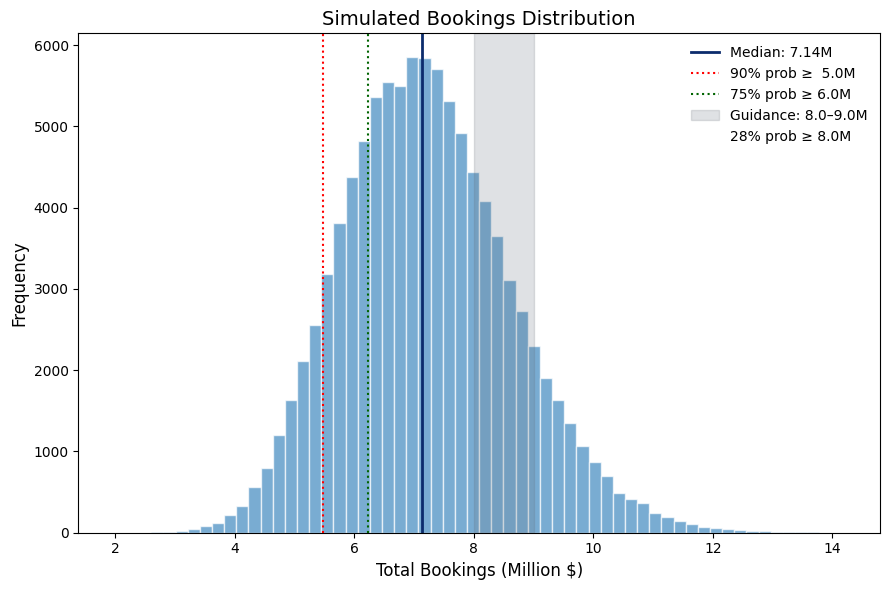

Median: $7,137,087 | 90% CI: $5,037,926–$9,695,568
P(hit 8,000,000–9,000,000) = 16.6%
P(bookings ≥ 8,000,000) = 27.5%
≥ @90% (p10): $5,000,000
≥ @75% (p25): $6,000,000


In [288]:
p05, p50, p95 = np.percentile(funnel_estimates, [5, 50, 95])

p10, p25 = np.percentile(funnel_estimates, [10, 25])

def round_to_millions(x): return round(x, -6)

p10_r, p25_r = round_to_millions(p10), round_to_millions(p25)


prob_guidance = ((funnel_estimates >= acquisition_guidance_band[0]) & (funnel_estimates <= acquisition_guidance_band[1])).mean()

low, high = acquisition_guidance_band  # e.g., (8_000_000, 10_000_000)

# Probability of hitting AT LEAST the low end of guidance
p_at_least_low = (funnel_estimates >= low).mean()


# --- Plot settings ---
hist_color   = "#4089bf"   # change to taste, e.g. "tomato", "#33a988"  #199ae6
line_color   = "#0c2c6c"
band_color   = "#636D78"

plt.figure(figsize=(9,6))

# Histogram
plt.hist(funnel_estimates/1e6, bins=60, color=hist_color, alpha=0.7, edgecolor="white")

# Percentile lines
#plt.axvline(p05/1e6, color="red", linestyle="--", linewidth=1.5, label=f"5th: {p05/1e6:.2f}M")
plt.axvline(p50/1e6, color=line_color, linestyle="-",  linewidth=2.0, label=f"Median: {p50/1e6:.2f}M")
#plt.axvline(p95/1e6, color="red", linestyle="--", linewidth=1.5, label=f"95th: {p95/1e6:.2f}M")

plt.axvline(p10/1e6, color="red", linestyle=":", linewidth=1.5,
            label=f"90% prob ≥  {p10_r/1e6:.1f}M ")
plt.axvline(p25/1e6, color="darkgreen", linestyle=":", linewidth=1.5,
            label=f"75% prob ≥ {p25_r/1e6:.1f}M ")


# Guidance band shading
plt.axvspan(acquisition_guidance_band[0]/1e6, acquisition_guidance_band[1]/1e6,
            color=band_color, alpha=0.2,
            label=f"Guidance: {acquisition_guidance_band[0]/1e6:.1f}–{acquisition_guidance_band[1]/1e6:.1f}M")

plt.axvline(low/1e6,  linewidth=2.0, color="white", linestyle="",
            label=f"{p_at_least_low:.0%} prob ≥ {low/1e6:.1f}M ")

# Labels & title
plt.xlabel("Total Bookings (Million $)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Simulated Bookings Distribution", fontsize=14)

# Legend
plt.legend(frameon=False)

# Grid for readability
plt.grid(axis="y", alpha=0.3)

# Save to file (PNG, high resolution for blog)
plt.tight_layout()
plt.savefig("bookings_histogram.png", dpi=300)

# plt.axvline(low/1e6, color="orange", linestyle=":",#funnel_estimates.max()/1e6, alpha=0.12,
#             label=f"P(≥ {low/1e6:.1f}M) = {p_at_least_low:.1%}")
#plt.legend(frameon=False)

# Show inline
plt.grid(False)
plt.show()

print(f"Median: ${p50:,.0f} | 90% CI: ${p05:,.0f}–${p95:,.0f}")
print(f"P(hit {acquisition_guidance_band[0]:,.0f}–{acquisition_guidance_band[1]:,.0f}) = {prob_guidance:.1%}")
print(f"P(bookings ≥ {low:,.0f}) = {p_at_least_low:.1%}")
print(f"≥ @90% (p10): ${p10_r:,.0f}")
print(f"≥ @75% (p25): ${p25_r:,.0f}")


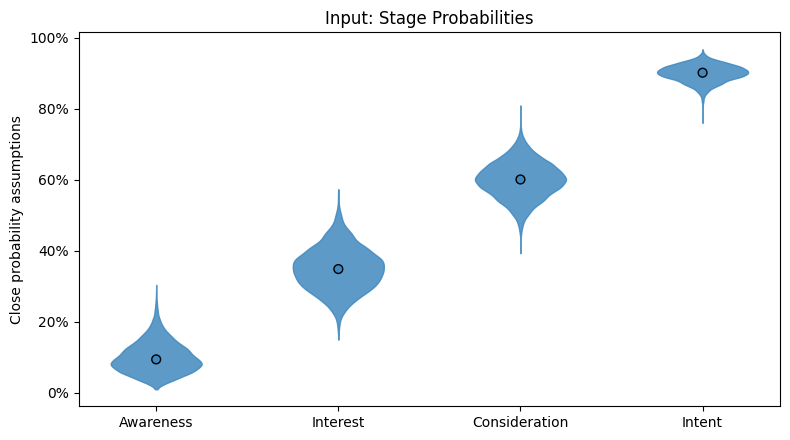

In [292]:

# --- Labels & indices ---
stage_labels = ["Awareness", "Interest", "Consideration", "Intent"]
stage_idx = np.repeat(np.arange(stage_probabilities.size), stage_counts)  # shape (D,)

# Pick one color per stage (order must match stage_labels / data order)
stage_colors = ["#4089bf", "#4089bf", "#4089bf", "#4089bf"]

# --- 1) Probability noise by stage (violin plot) ---
prob_plot_rows = min(10_000, win_probabilities_stage.shape[0])
prob_rows = rng.choice(win_probabilities_stage.shape[0], prob_plot_rows, replace=False)
prob_samples_by_stage = [win_probabilities_stage[prob_rows, j] for j in range(stage_probabilities.size)]

fig1, ax1 = plt.subplots(figsize=(8, 4.5))
parts = ax1.violinplot(prob_samples_by_stage, showmeans=False, showmedians=False, showextrema=False)

# Color each violin by stage
for body, col in zip(parts['bodies'], stage_colors):
    body.set_facecolor(col)
    body.set_edgecolor("#4089bf")
    body.set_alpha(0.85)

# Mark stage medians (colored to match violins)
meds = [np.median(s) for s in prob_samples_by_stage]
ax1.scatter(
    np.arange(1, len(meds)+1),
    meds,
    marker='o',
    s=40,
    c=stage_colors,
    edgecolors="black",
    zorder=3
)

# Axes formatting
ax1.set_xticks(np.arange(1, len(stage_labels)+1))
ax1.set_xticklabels(stage_labels)
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax1.set_ylabel("Close probability assumptions")
ax1.set_title("Input: Stage Probabilities")
ax1.grid(True, alpha=0.3)

# Legend
legend_handles = [Patch(facecolor=stage_colors[i], edgecolor="black", label=stage_labels[i])
                  for i in range(len(stage_labels))]
#ax1.legend(handles=legend_handles, title="Stage", frameon=False, loc="upper left")

plt.tight_layout()
plt.grid(False)
plt.show()
